In [1]:
import os
os.environ["TORCH_USE_NNPACK"] = "0"
import warnings
warnings.filterwarnings("ignore", message=".*NNPACK.*")


In [2]:
import gymnasium as gym
from gymnasium.wrappers import NumpyToTorch, DtypeObservation
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import torch as T
from torch import nn

In [3]:
env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
env = DtypeObservation(env, np.float32)
env = NumpyToTorch(env)

In [4]:
env.action_space

Box([-1.  0.  0.], 1.0, (3,), float32)

In [5]:
env.observation_space

Box(0.0, 255.0, (96, 96, 3), float32)

In [6]:
state, info = env.reset()
state.shape, type(state), info, state.max(), state.min()

(torch.Size([96, 96, 3]), torch.Tensor, {}, tensor(229.), tensor(0.))

In [7]:
img = env.render().numpy()
img.shape

(400, 600, 3)

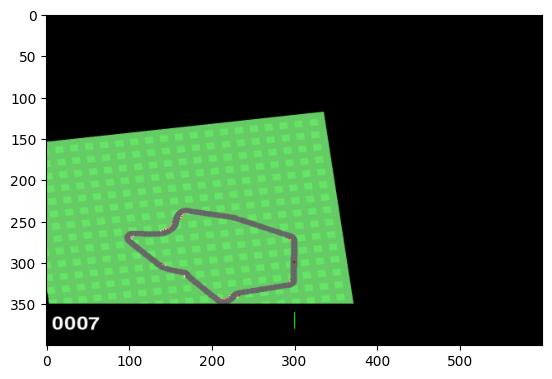

In [8]:
plt.imshow(img)

In [9]:
transposed_state = state.permute(2, 0, 1).to(T.float32)
transposed_state.shape, transposed_state.dtype

(torch.Size([3, 96, 96]), torch.float32)

In [10]:
T.tensor([[0, 1, 1]]).shape

torch.Size([1, 3])

In [11]:
def reshape_output(x: T.Tensor) -> T.Tensor:
    reshaped_tensor = x + T.tensor([[0, 1, 1]])
    reshaped_tensor /= T.tensor([[1, 2, 2]])
    return reshaped_tensor

In [18]:
class CarRacingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 5, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 5, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1),
            nn.BatchNorm2d(256),
        )
        self.pool = nn.MaxPool2d(3)
        self.gru_cell = nn.GRUCell(256, 128)
        self.action_head = nn.Sequential(
            nn.Linear(128, 1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3),
            nn.Tanh()
        )

        self.value_head = nn.Sequential(
            nn.Linear(128, 1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1),
        )
    
    def forward(self, input: T.Tensor, hx: T.Tensor | None = None) -> Tuple[T.Tensor, T.Tensor, T.Tensor]:
        if len(input.shape) == 3:
            input = input.unsqueeze(0)
        feature_map = self.conv(input)
        pooled_feature_map = self.pool(feature_map).flatten(1)
        hx = self.gru_cell(pooled_feature_map, hx)
        action = self.action_head(hx)
        reshaped_action = reshape_output(action)
        value = self.value_head(hx)
        return reshaped_action, value, hx

        

In [19]:
model = CarRacingModel()

In [20]:
action, value, hx = model(transposed_state)
action.shape, value.shape, hx.shape

[W1224 14:13:37.926841290 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.


(torch.Size([1, 3]), torch.Size([1, 1]), torch.Size([1, 128]))

In [37]:
def stack_buffer(replay_buffer: list):
    return (T.stack(col, dim=0) for col in zip(*replay_buffer))

In [ ]:
NUM_EPOCHS = 10
replay_buffer = []
i = 0

for epoch in range(NUM_EPOCHS):
    state, _ = env.reset()
    state = state.permute(2, 0, 1).to(T.float32)
    total_reward = 0
    done = False
    hx = T.zeros((1, 128))
    
    while not done:
        with T.no_grad():
            action, value, hx = model(state, hx)
        action.squeeze_(0)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = next_state.permute(2, 0, 1).to(T.float32)
        done = terminated or truncated
        
        replay_buffer.append(
            (state, next_state, action, value.squeeze(0), T.tensor([reward], dtype=T.float32), T.tensor([done], dtype=T.bool))
        )
        
        state = next_state
        
        if i > 0 and i % 32 == 0:
            # calculcate loss
            pass
        i += 1
        total_reward += reward
    print("Epoch", epoch, "reward", total_reward)
        
        
    

[W1224 14:16:25.517713810 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.557174284 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.590724228 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.629272936 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.650965716 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.673844683 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.694530790 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.714639855 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.741160186 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
[W1224 14:16:25.776805883 NNPACK.cpp:56] Could not initialize NNPACK! Reason: Unsupported hardware.
